# Hard and soft constraints

### Hard constraints
These are constraints that must be pursued during the search and without meeting these constraints, the solution is not true. These constraints are:
- All classes must be scheduled
- No classes or lecturers are allocated twice at same time

### Soft constraints
These constraints that are not mandatory for a solution must be pursued, but the quality of the courses schedule is decided by following these constraints
- classes scheduled within preferred hours
- Avoid long runs of consecutive lectures

# Initialization

In [167]:
import numpy as np
from numpy import random
from itertools import product
from prettytable import PrettyTable
import csv

In [168]:
# Initialization to convert input from user into a single data
def initialize(students, courses, day_times, prof_input):
    initialized_data = {}
    initialized_data["stgs"] = students
    initialized_data["courses"] = courses
    initialized_data["days"] = day_times["days"]
    initialized_data["periods"] = day_times["periods"]
    availability_product = list(product(initialized_data["days"], initialized_data["periods"]))
    availability_list = [list(elem) for elem in availability_product]
    prof_data = {}
    for prof in prof_input.keys():
        current_available = availability_list.copy()
        unavailables = prof_input[prof]["unavailable"]
        for elem in unavailables:
            current_available.remove(elem)
        prof_data[prof]= {"availability_list" : current_available}
    initialized_data["profs"] = prof_data
    return initialized_data

In [169]:
# Generating a random initial population
def generate_population(n, input_data):
    stgs = [ key for key in input_data["stgs"].keys()]
    courses = [ key for key in input_data["courses"].keys()]
    profs = [key for key in input_data["profs"].keys()]
    days = input_data["days"]
    periods = input_data["periods"]
    chromosome_length = 0
    for stg in stgs:
        chromosome_length += input_data["stgs"][stg]["hour"]

    population = []
    for _ in range(n):
        cur_individual = []
        for _ in range(chromosome_length):
            stg = random.choice(stgs)
            course = random.choice(courses)
            prof = random.choice(profs)
            day = random.choice(days)
            period = random.choice(periods)
            cur_chromosome = {"stg": stg, "course": course, "prof": prof,
            "day": day, "period": period}
            cur_individual.append(cur_chromosome)
        population.append(cur_individual)
    return population

# Evolutionary functions

In [170]:
# Fitness function
# TODO: add soft constraints
def fitness_function(matrix, data):
    stgs = [ key for key in data["stgs"].keys()]
    courses = [ key for key in data["courses"].keys()]
    profs = [key for key in data["profs"].keys()]
    stg_checker = {}
    course_checker = {}
    prof_checker = {}
    for stg in stgs:
        stg_checker[stg] = []
    for prof in profs:
        prof_checker[prof] = []
    for course in courses:
        course_checker[course] = 0

    hard_penalty_counter = 0
    for chromosome in matrix:
        stg = chromosome["stg"]
        course = chromosome["course"]
        prof = chromosome["prof"]
        day = chromosome["day"]
        period = chromosome["period"]
        course_checker[course] += 1
        if course not in data["stgs"][stg]["course_list"]:
            hard_penalty_counter += 1
        if prof not in data["courses"][course]["prof_list"]:
            hard_penalty_counter += 1
        timeslot = [day, period]
        if timeslot not in stg_checker[stg]:
            stg_checker[stg].append(timeslot)
        else:
            hard_penalty_counter += 1
        if timeslot not in prof_checker[prof]:
            prof_checker[prof].append(timeslot)
        else:
            hard_penalty_counter += 1
        if timeslot not in data["profs"][prof]["availability_list"]:
            hard_penalty_counter += 1
    for course_key in course_checker.keys():
        if course_checker[course_key] != data["courses"][course_key]["hour"]:
            abs_diff = np.abs(course_checker[course_key] - data["courses"][course_key]["hour"]) 
            hard_penalty_counter += abs_diff
    for stg in stgs:
        if len(stg_checker[stg]) != data["stgs"][stg]["hour"]:
            abs_diff = np.abs(len(stg_checker[stg]) - data["stgs"][stg]["hour"]) 
            hard_penalty_counter += abs_diff
    
    # Check for soft constraints
    soft_penalty_counter = 0

    hard_penalty_resolved = True if hard_penalty_counter == 0 else False

    result = 1/(1+(soft_penalty_counter + hard_penalty_counter))
    return result, hard_penalty_resolved

In [171]:
# One point crossover from index 1 to last index
def one_point_crossover(parent_1, parent_2, crossover_rate=0.8):
    crossover_point = random.randint(1, len(parent_1))
    child_1 = parent_1.copy()
    if (random.random() < crossover_rate):
        child_1[crossover_point:] = parent_2[crossover_point:]
    return child_1

In [172]:
# Mutation by Random resetting
def mutation(individual, input_data, mutation_rate=0.02):
    stgs = [ key for key in input_data["stgs"].keys()]
    courses = [ key for key in input_data["courses"].keys()]
    profs = [key for key in input_data["profs"].keys()]
    days = input_data["days"]
    periods = input_data["periods"]
    for mutate_index in range(len(individual)):
        mutation_prob = random.random()
        if (mutation_prob < mutation_rate):
            mutate_attr = random.randint(len(individual))
            if mutate_attr == 0:
                individual[mutate_index]["stg"] = random.choice(stgs)
            if mutate_attr == 1:
                individual[mutate_index]["course"] = random.choice(courses)
            if mutate_attr == 2:
                individual[mutate_index]["prof"] = random.choice(profs)
            if mutate_attr == 3:
                individual[mutate_index]["day"] = random.choice(days)
            if mutate_attr == 4:
                individual[mutate_index]["period"] = random.choice(periods)
    return individual

In [173]:
# Selection by ranking
# Choose top 0.1 and then reproduce until same length as population
def get_new_population_selection_by_ranking(population, fitness_values, data):
    zipped_population = [(x,y) for x,y in zip(population, fitness_values)]
    sorted_population = sorted(zipped_population,key=lambda x: x[1], reverse=True)
    population_length = len(population)
    elites = sorted_population[:population_length//10]
    elites = [x[0] for x in elites]
    new_gen = []
    for _ in range(population_length):
        parent_x_idx = random.randint(len(elites))
        parent_y_idx = random.randint(len(elites))
        while parent_x_idx == parent_y_idx:
            parent_y_idx = random.randint(len(elites))
        parent_x, parent_y = elites[parent_x_idx], elites[parent_y_idx]
        child_1= one_point_crossover(parent_x, parent_y)
        mutated_1= mutation(child_1, data)
        new_gen.append(mutated_1)
    return new_gen

In [174]:
# Main genetic algorithm function
def genetic_algorithm(input_fitness_values, input_population, input_data, DEBUG=False, debug_num=100):
    counter = 0
    current_fitness_values = input_fitness_values.copy()
    current_population = input_population.copy()
    solution = {}
    avg_fitness_list = []
    max_fitness_list = []
    while True:
        new_population = get_new_population_selection_by_ranking(current_population, current_fitness_values, input_data)
        new_fitness_values= []
        is_solution_checker = []
        for idx in range(len(new_population)):
            fitness_value, is_solution = fitness_function(new_population[idx], input_data)
            new_fitness_values.append(fitness_value)
            is_solution_checker.append(is_solution)
        for i in range(len(new_fitness_values)):
            if new_fitness_values[i] > current_fitness_values[i]:
                current_population[i] = new_population[i]
                current_fitness_values[i] = new_fitness_values[i]
        counter += 1
        max_fitness = np.max(current_fitness_values)
        avg_fitness = np.mean(current_fitness_values)
        max_fitness_list.append(max_fitness)
        avg_fitness_list.append(avg_fitness)
        if True in is_solution_checker:
            index = is_solution_checker.index(True)
            print("SOLUTION FOUND", "\nGeneration count:", counter, "\nSolution:", new_population[index])
            solution = new_population[index]
            break
        if DEBUG:
            if counter % debug_num == 0:
                print(counter, max_fitness, avg_fitness)
    return solution, avg_fitness_list, max_fitness_list

# Input (Program begins here)

#### Functions to assign course and professor names

In [175]:
def assign_courses(input_data):
    assigned_courses = {}
    courses = [ key for key in input_data["courses"].keys()]
    words = list(csv.reader(open("courses.csv")))
    for course in courses:
        rand_num = random.randint(len(words))
        rand_course = words[rand_num][0]
        assigned_courses[course] = rand_course
    return assigned_courses

In [176]:
def assign_profs(input_data):
    assigned_profs = {}
    profs = [ key for key in input_data["profs"].keys()]
    words = list(csv.reader(open("profs.csv")))
    for prof in profs:
        rand_num = random.randint(len(words))
        rand_prof = "Prof. " + words[rand_num][0]
        assigned_profs[prof] = rand_prof
    return assigned_profs

#### Different kinds of input

In [177]:
def easy_input():
    # Code for creating an input
    # Number of population = number student gouweekly hours
    student_input = {0: {"hour": 4, "course_list": [0]}, 1: {"hour": 3, "course_list": [1]}}
    course_input = {0: {"hour": 4, "prof_list": [0, 1]}, 1: {"hour": 3, "prof_list": [0, 1]}}
    day_time_availability = {"days": [0,1,2,3,4], "periods": [0,1,2,3,4,5,6,7,8]}
    # [[day, period]]
    prof_input = {0: {"unavailable": [] }, 1: {"unavailable": []}}
    initialized_data = initialize(student_input, course_input, day_time_availability, prof_input)
    return initialized_data

#### Choosing which degree of input will be used for the algorithm

In [178]:
initialized_data = easy_input()

assigned_courses = assign_courses(initialized_data)
assigned_profs = assign_profs(initialized_data)

print(initialized_data)
stgs = [ key for key in initialized_data["stgs"].keys()]
courses = [ key for key in initialized_data["courses"].keys()]
profs = [key for key in initialized_data["profs"].keys()]
days = initialized_data["days"]
periods = initialized_data["periods"]

{'stgs': {0: {'hour': 4, 'course_list': [0]}, 1: {'hour': 3, 'course_list': [1]}}, 'courses': {0: {'hour': 4, 'prof_list': [0, 1]}, 1: {'hour': 3, 'prof_list': [0, 1]}}, 'days': [0, 1, 2, 3, 4], 'periods': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'profs': {0: {'availability_list': [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8]]}, 1: {'availability_list': [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6

#### Generating initial population

In [179]:
population_num = 100
initial_population = generate_population(population_num, initialized_data)
initial_fitness_values = []
for idx in range(len(initial_population)):
    fitness_value, _ = fitness_function(initial_population[idx], initialized_data)
    initial_fitness_values.append(fitness_value)
print(np.max(initial_fitness_values), np.mean(initial_fitness_values))

0.3333333333333333 0.12494630369630366


#### Calling the genetic algorithm function

In [180]:
solution, avg_fitness_list, max_fitness_list = genetic_algorithm(initial_fitness_values, initial_population, initialized_data)

SOLUTION FOUND 
Generation count: 72 
Solution: [{'stg': 0, 'course': 0, 'prof': 0, 'day': 4, 'period': 7}, {'stg': 1, 'course': 1, 'prof': 0, 'day': 4, 'period': 6}, {'stg': 0, 'course': 0, 'prof': 0, 'day': 2, 'period': 7}, {'stg': 0, 'course': 0, 'prof': 1, 'day': 2, 'period': 1}, {'stg': 1, 'course': 1, 'prof': 1, 'day': 1, 'period': 0}, {'stg': 1, 'course': 1, 'prof': 1, 'day': 3, 'period': 5}, {'stg': 0, 'course': 0, 'prof': 0, 'day': 3, 'period': 6}]


# Timetable showcase

In [187]:
def get_mapped_value(value, value_type, input_dict={}):
    result = ""
    if value_type == "days":
        if value == 0:
            result = "Monday"
        if value == 1:
            result = "Tuesday"
        if value == 2:
            result = "Wednesday"
        if value == 3:
            result = "Thursday"
        if value == 4:
            result = "Friday"
        if value == 5:
            result = "Saturday"
        if value == 6:
            result = "Sunday"
        if value <= 0 or value >= 7:
            result = "Day " + str(value)
    
    if value_type == "periods":
        time_from = value + 8
        time_to = time_from + 1
        result = str(time_from).zfill(2) + ":00" + " - " + str(time_to).zfill(2) + ":00"

    if value_type == "courses":
        result = input_dict[value]
    
    if value_type == "profs":
        result = input_dict[value]
    return result

for stg in stgs:
    table = PrettyTable()
    table.title = 'Schedule for student group ' + str(stg + 1)
    field_names = ['']
    for day in days:
        day = get_mapped_value(day, "days")
        field_names.append(day)
    table.field_names = field_names
    rows = []
    for period_num in periods:
        current_period = [get_mapped_value(period_num, "periods")]
        for _ in days:
            current_period.append("")
        rows.append(current_period)
    for chromosome in solution:
        if chromosome['stg'] == stg:
            chr_day = chromosome['day']
            chr_period = chromosome['period']
            chr_course = chromosome['course']
            chr_course = get_mapped_value(chr_course, "courses", assigned_courses)
            chr_prof = chromosome['prof']
            chr_prof = get_mapped_value(chr_prof, "profs", assigned_profs)
            day_idx = days.index(chr_day)
            period_idx = periods.index(chr_period)
            rows[period_idx][day_idx + 1] = chr_course + "\n- " + chr_prof
        
    for row in rows:
        table.add_row(row)

    print(table)

+---------------------------------------------------------------------------------------+
|                              Schedule for student group 1                             |
+---------------+-------+---------+-----------------+-----------------+-----------------+
|               | Day 0 | Tuesday |    Wednesday    |     Thursday    |      Friday     |
+---------------+-------+---------+-----------------+-----------------+-----------------+
| 08:00 - 09:00 |       |         |                 |                 |                 |
| 09:00 - 10:00 |       |         |     Zoology     |                 |                 |
|               |       |         |  - Prof. Benoit |                 |                 |
| 10:00 - 11:00 |       |         |                 |                 |                 |
| 11:00 - 12:00 |       |         |                 |                 |                 |
| 12:00 - 13:00 |       |         |                 |                 |                 |
| 13:00 - 

# Performance evaluation

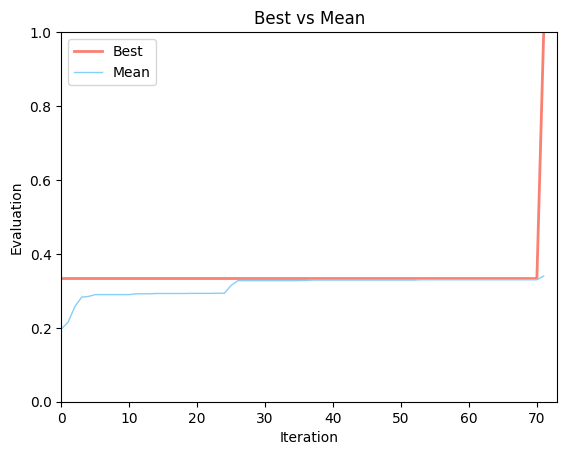

In [182]:
import matplotlib.pyplot as plt

x_limit = len(avg_fitness_list) + len(avg_fitness_list)//50
y_limit_high = np.max(max_fitness_list)

plt.xlim(0, x_limit)
plt.ylim(0, y_limit_high)
plt.plot(max_fitness_list, linewidth=2, color="salmon")
plt.plot(avg_fitness_list, linewidth=1, color="lightskyblue")
plt.ylabel("Evaluation")
plt.xlabel("Iteration")
plt.legend(["Best", "Mean"], loc="upper left")
plt.title("Best vs Mean")
plt.show()

In [183]:
# from matplotlib.animation import FuncAnimation
# plt.style.use("seaborn-pastel")
# fig, ax = plt.subplots()
# fig.set_size_inches(10, 5)

# def init():
#     ax.set(
#         xlim=(0, x_limit),
#         ylim=[min(avg_fitness_list), max(max_fitness_list)],
#         title="Best vs Mean",
#         xlabel="Iteration",
#         ylabel="Evaluation",
#     )

# def update(i):
#     l1 = plt.plot(np.array(max_fitness_list[:i]), linewidth=2, color="salmon")
#     l2 = plt.plot(np.array(avg_fitness_list[:i]), linewidth=1, color="lightskyblue")
#     plt.legend(["Best", "Mean"], loc="upper left")

# anim = FuncAnimation(fig, update, frames=x_limit, init_func=init, interval=1)
# anim.save("animation.gif", writer="imagemagick")
# plt.show()